import all functions from file

In [1]:
from tool.functions import *

** One-time **

In [ ]:
download_all_bidixes()

2018-06-29 16:18:09,828 | INFO : Start


For now I delete ces-ces, ita-ita, eus-eu_bis, hbs_HR-hbs_SR, zh_CN-zh_TW

In [2]:
%time monodix()

2018-06-29 16:36:44,353 | INFO : started
2018-06-29 16:40:23,164 | INFO : finished
Wall time: 3min 38s


In [2]:
%time get_relevant_languages('spa', 'eng')

Wall time: 44 ms


In [1]:
from tool.functions import load_file, change_encoding, built_from_file

In [2]:
%time load_file('spa', 'eng')

2018-06-11 22:32:06,560 | INFO : cat-ita started
2018-06-11 22:32:39,285 | INFO : eng-cat started
2018-06-11 22:37:19,892 | INFO : eng-ita started
2018-06-11 22:38:54,490 | INFO : eng-spa started
2018-06-11 22:41:22,105 | INFO : fra-cat started
2018-06-11 22:45:20,731 | INFO : fra-eng started
2018-06-11 22:46:16,861 | INFO : fra-ita started
2018-06-11 22:46:48,962 | INFO : fra-spa started
2018-06-11 22:48:43,558 | INFO : spa-cat started
2018-06-11 22:53:54,753 | INFO : spa-ita started
Wall time: 22min 55s


In [3]:
%time change_encoding('spa-eng')

Wall time: 296 ms


** Load **

In [2]:
%time G = built_from_file('spa-eng')
%time l1, l2 = dictionaries('spa', 'eng')
'Edges: {}  Nodes: {}'.format(len(G.edges()),len(G.nodes()))

Wall time: 32.2 s
Wall time: 6.95 s


'Edges: 538634  Nodes: 285935'

** Search **

In [3]:
%timeit s = possible_translations(G, Word('be','eng',[Tags(['vblex']),Tags(['vblex','pp'])]), 'spa', cutoff=8, n=40)
%timeit s = nx.single_source_shortest_path_length(G, Word('be','eng',[Tags(['vblex']),Tags(['vblex','pp'])]),cutoff=8)

2.53 ms ± 279 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
352 ms ± 54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
def evaluation(G, word, candidates, metric, cutoff=4):
    result = {}
    for translation in candidates:
        result[translation] = metric(G, word, translation, cutoff=cutoff)
    return result

def lemma_search (G, lemma, d_l1, l2, cutoff, n):
    lemmas = [i for i in d_l1.lemma(lemma) if i in G.nodes()]
    results = {word:{} for word in lemmas}
    for word in lemmas:
        candidates = possible_translations(G, word, l2, cutoff=cutoff, n=n)
        results[word] = evaluation(G, word, candidates, metric, cutoff=cutoff)
        del candidates
    return results

def metric(G, word, translation, cutoff, mode='exp'):
    coef = 0
    if mode in ('exp'):
        t = Counter([len(i) for i in nx.all_simple_paths(G, word, translation, cutoff=cutoff)])
        if mode == 'exp': 
            for i in t: 
                coef += exp(-t[i])
            return coef

In [8]:
%time print_lemma_results(lemma_search (G, 'star', l2, 'spa', 4, 40), n = 5)

		 eng$star$[vblex]
spa$protagonizar$[vblex]	1.103638323514327
spa$jugar$[vblex_vblex-vbact]	0.13567074586451522
spa$obrar$[vblex]	0.1353352832366127
spa$hacer$[vblex_vblex-inf]	0.1353352832366127
spa$alivianarse$[vblex-pron]	0.1353352832366127

		 eng$star$[n_n-ND]
spa$astro$[n_n-m]	0.6385500076446677
spa$cometa$[n-m_n]	0.4176665095393063
spa$cometa$[n-f_n_n-f-sg]	0.4176665095393063
spa$estrella$[n-f_n_n-f-sg]	0.37461750070570254
spa$barrilete$[n-m_n]	0.36787944117144233

Wall time: 129 ms


In [5]:
%time s = lemma_search (G, 'capital', l1, 'eng', 4, 40)
%time s = lemma_search (G, 'capital', l1, 'eng', 6, 40)
%time s = lemma_search (G, 'capital', l1, 'eng', 8, 40)

Wall time: 74.9 ms
Wall time: 178 ms
Wall time: 1.58 s


In [6]:
%time s = lemma_search (G, 'casa', l1, 'eng', 4, 40)
%time s = lemma_search (G, 'casa', l1, 'eng', 6, 40)
%time s = lemma_search (G, 'casa', l1, 'eng', 8, 40)

Wall time: 90.9 ms
Wall time: 515 ms
Wall time: 9.36 s


** Evaluate on spa-eng **

In [3]:
%time l1, l2 = dictionaries('spa', 'eng')
%time G = built_from_file('spa-eng')

Wall time: 4.6 s
Wall time: 32.3 s


In [11]:
import random
def get_evaluation_pairs(G, dictionary, target, n=500):
    k = 4
    pairs = []
    while len(pairs) < n:
        candidates = random.sample(dictionary, k*n)
        pairs = []
        for i in candidates:
            if i in G.nodes():
                s = FilteredList(list(G.neighbors(i))).lang(target)
                if len(s) == 1: pairs.append((i, s[0], n))
        print (k*n, len(pairs))
        k+=1
    return pairs[:n]

In [5]:
%time s = get_evaluation_pairs(G, l1, 'eng', n=1000)

4000 950
5000 1171
Wall time: 174 ms


In [9]:
def node_search(G, word, lang, cutoff):
    if word not in G.nodes(): return None
    results = {}
    candidates = possible_translations(G, word, lang, cutoff=cutoff, n=30)
    results = evaluation(G, word, candidates, metric, cutoff=cutoff)
    return list(sorted(results, key=results.get, reverse=True))[:20]

def two_node_search (G, node1, node2, l1, l2, cutoff):
    if (node1, node2) in G.edges(): G.remove_edge(node1, node2)
    if (node2, node1) in G.edges(): G.remove_edge(node2, node1)
    res1 = node_search(G, node1, l2, cutoff)
    res2 = node_search(G, node2, l1, cutoff)
    coefficient = 0
    if node2 in res1: coefficient += 0.5*(len(res1) - res1.index(node2))/len(res1)
    if node1 in res2: coefficient += 0.5*(len(res2) - res2.index(node1))/len(res2) 
    return coefficient

def evaluate_graph(G, pairs, l1, l2, cutoff):
    result = []
    for i in pairs:
        result.append(two_node_search (G, i[0], i[1], l1, l2, cutoff))
    return result

In [79]:
node_search(G, s[2][0], 'eng', 6)

spa$teta$[n_n-f] eng [eng$udder$[n], eng$breast$[n_n-ND], eng$mum$[n_n-ND], eng$heart$[n_n-ND], eng$sinus$[n], eng$chest$[n_n-sg]]


[spa$teta$[n_n-f]]

In [75]:
s[7]

(spa$coherentemente$[adv], eng$consistently$[adv], 100)

In [81]:
possible_translations(G, s[7][0], 'eng', cutoff=4, n=30)

[eng$consistently$[adv]]

In [76]:
lemma_search (G, 'coherentemente', l1, 'eng', 4, 40)

{spa$coherentemente$[adv]: {eng$consistently$[adv]: 0.1353352832366127}}

In [98]:
two_node_search (G, s[7][0], s[7][1], 'spa', 'eng', 4)

0.6666666666666666

In [99]:
s[:10]

[(spa$Hoel$[np-ant], eng$Hoel$[np-ant_np-ant-m-sg_np], 100),
 (spa$lo siento$[adv], eng$I'm sorry$[adv], 100),
 (spa$teta$[n_n-f], eng$tit$[n], 100),
 (spa$frenesí$[n_n-m], eng$frenzy$[n], 100),
 (spa$plástico$[adj_adj-GD], eng$plastic$[adj], 100),
 (spa$Soderbergh$[np-cog-mf], eng$Soderbergh$[np-cog-sg__np-cog], 100),
 (spa$estrenar$[vblex], eng$première$[vblex], 100),
 (spa$coherentemente$[adv], eng$consistently$[adv], 100),
 (spa$AK-47$[np-al-f], eng$AK-47$[np-al], 100),
 (spa$Lisbeth$[np-ant], eng$Lisbeth$[np-ant_np-ant-f-sg_np], 100)]

In [15]:
%time result = evaluate_graph(G, s, 'spa', 'eng', 4)
sum(result)/10

Wall time: 13.6 s


54.020900855680296

In [16]:
%time result = evaluate_graph(G, s, 'spa', 'eng', 6)
sum(result)/10

Wall time: 13.7 s


55.000515318015346

In [17]:
%time result = evaluate_graph(G, s, 'spa', 'eng', 8)
sum(result)/10

Wall time: 14.2 s


55.19614245231895

In [18]:
%time result = evaluate_graph(G, s, 'spa', 'eng', 10)
sum(result)/10

Wall time: 17.9 s


55.27214710362739

In [19]:
%time result = evaluate_graph(G, s, 'spa', 'eng', 12)
sum(result)/10

Wall time: 16.1 s


55.292220805510304

** Evaluation on rus-ukr **

In [20]:
get_relevant_languages('rus', 'ukr')

In [2]:
%time load_file('rus', 'ukr')

2018-06-16 22:28:35,909 | INFO : bel-rus started
2018-06-16 22:29:03,539 | INFO : bul-eng started
2018-06-16 22:29:13,453 | INFO : bul-rus started
2018-06-16 22:29:17,721 | INFO : ces-hbs started
2018-06-16 22:29:18,328 | INFO : ces-rus started
2018-06-16 22:29:26,349 | INFO : chv-rus started
2018-06-16 22:29:27,317 | INFO : chv-tat started
2018-06-16 22:29:28,280 | INFO : eng-kaz started
2018-06-16 22:30:11,873 | INFO : eng-pol started
2018-06-16 22:30:22,155 | INFO : epo-bel started
2018-06-16 22:30:24,693 | INFO : epo-bul started
ERROR: epo-bul
2018-06-16 22:30:26,879 | INFO : epo-ces started
2018-06-16 22:30:28,804 | INFO : epo-eng started
2018-06-16 22:30:56,654 | INFO : epo-pol started
ERROR: epo-pol
2018-06-16 22:30:59,037 | INFO : epo-rus started
2018-06-16 22:31:30,501 | INFO : hbs-eng started
2018-06-16 22:32:02,061 | INFO : hbs-rus started
2018-06-16 22:32:12,185 | INFO : isl-eng started
2018-06-16 22:32:19,999 | INFO : isl-rus started
2018-06-16 22:32:20,935 | INFO : kaz-ru

In [3]:
%time change_encoding('rus-ukr')

Wall time: 341 ms


In [4]:
%time l1, l2 = dictionaries('rus', 'ukr')
%time G = built_from_file('rus-ukr')

Wall time: 1.06 s
Wall time: 34.8 s


In [13]:
%time s = get_evaluation_pairs(G, l1, 'ukr', n=1000)

4000 497
5000 631
6000 754
7000 886
8000 1031
Wall time: 616 ms


In [14]:
%time result = evaluate_graph(G, s, 'rus', 'ukr', 4)
sum(result)/10

Wall time: 17.6 s


14.175800792774487

In [15]:
%time result = evaluate_graph(G, s, 'rus', 'ukr', 6)
print(sum(result)/10)
%time result = evaluate_graph(G, s, 'rus', 'ukr', 8)
print(sum(result)/10)
%time result = evaluate_graph(G, s, 'rus', 'ukr', 10)
print(sum(result)/10)

Wall time: 33.2 s
15.10937769359982
Wall time: 39.5 s
15.289583153774325
Wall time: 39.7 s
15.304539835164828


There are only 3K words in only dictionary that is connected with UKR (pol-ukr)

In [12]:
try:0/0
except: print (8)

8


# Relevant languages

### Bidix weights

In [2]:
from tool.functions import *
class DictionaryStats:
    def __init__(self, file):
        self.file = file
        self.name1 = file.replace('.dix','').split('-')[0]
        self.name2 = file.replace('.dix','').split('-')[1]
        self.mono1 = import_mono(self.name1)
        self.mono2 = import_mono(self.name2)
        self.count1 = 0
        self.count2 = 0
        self.count = 0
        self.set1 = set()
        self.set2 = set()
        self.get_data()
    
    def get_data(self):
        with open ('./dictionaries/'+self.file, 'r', encoding='utf-8') as d:
            with open ('./parsed/'+self.file, 'w', encoding='utf-8') as copy:
                try:
                    tree = ET.fromstring(re.sub('\s{3,}','\t', d.read().replace('<b/>',' ').replace('<.?g>','')))
                    for word1, word2, side in parse_bidix (tree, self.name1, self.name2):
                        try:
                            word1, word2 = check (word1, word2, self.mono1, self.mono2)
                            if word1 not in self.set1: 
                                self.count1 += 1
                                self.set1.add(word1)
                            if word2 not in self.set2:
                                self.count2 += 1
                                self.set2.add(word2)   
                            self.count += 1
                            string = str(side) + '\t' + word1.write(mode='bi') + '\t' + word2.write(mode='bi') + '\n'
                            copy.write(string)
                        except: pass
                except: pass
            
    def get_stats(self):
        return [self.count, self.count1/len(self.mono1), self.count1/len(self.mono2)]

In [3]:
from tqdm import tqdm_notebook as tqdm

def preprocessing():
    if not os.path.exists('./parsed/'):
        os.makedirs('./parsed/')
    with open ('./files/stats.csv','w', encoding='utf-8') as outp:
        #outp.write('{}\t{}\t{}\t{}\t{}\n'.format('lang1','lang2','total','1','2'))
        for root, dirs, files in os.walk('./dictionaries/'):
            for fl in tqdm(files):
                try:
                    pair = fl.replace('.dix','').split('-')
                    outp.write ('\t'.join(pair) + '\t'+ '\t'.join([str(i) for i in DictionaryStats(fl).get_stats()])+'\n')
                except:
                    pass

In [3]:
preprocessing()

### Interpret table

In [26]:
import networkx as nx
import math
def get_relevant_languages(source, target):
    G = nx.Graph()
    with open ('./files/stats.csv', 'r', encoding='utf-8') as f:
        for line in f:
            data = line.split('\t')
            coef = 1/math.log10(10+float(data[2])*float(data[3])*float(data[4]))
            if coef < 1:
                G.add_edge(data[0], data[1], weight=coef)
    if (source, target) in G.edges():
        print ('There is {}-{} dictionary'.format(source, target))
        G.remove_edge(source, target)
    medium = set(G.nodes()) - set([source,target])
    s_dist, s_path = nx.single_source_dijkstra(G, source)
    t_dist, t_path = nx.single_source_dijkstra(G, target)
    result = {}
    for node in G.nodes():
        if node in s_dist and node in t_dist:
            result[node] = (s_dist[node]+t_dist[node], s_path[node]+list(reversed(t_path[node]))[1:])
    with open ('language_list.csv','w', encoding='utf-8') as f:
        for i in sorted(result, key=result.get):
            f.write(str(result[i][0])+'\t'+str(i)+'\t:\t'+' '.join(result[i][1])+'\n')

In [27]:
from itertools import islice
def load_file(l1,l2, n=10000):
    with open ('language_list.csv','r',encoding='utf-8') as f:
        languages = set([i.split('\t')[1].strip() for i in islice(f.readlines(), 0, n)])
    languages = languages | set([l1,l2])
    with open ('{}-{}'.format(l1, l2), 'w', encoding='utf-16') as f:
        for root, dirs, files in os.walk ('./parsed/'):
            for fl in files:
                pair = fl.replace('.dix','').split('-')
                if existance(pair, languages):
                    #print (pair)
                    with open (root+fl, 'r', encoding='utf-8') as d:
                        f.write(d.read())
    #print (languages)

In [29]:
import matplotlib.pyplot as plt
def check_graph(l1, l2, n=10):
    G = nx.Graph()
    with open ('./files/stats.csv', 'r', encoding='utf-8') as f:
        for line in f:
            data = line.split('\t')
            coef = 1/math.log10(10+float(data[2])*float(data[3])*float(data[4]))
            if coef < 1:
                G.add_edge(data[0], data[1], weight=coef)
    if (l1, l2) in G.edges():
        G.remove_edge(l1, l2)
    with open ('language_list.csv','r',encoding='utf-8') as f:
        languages = set([i.split('\t')[1].strip() for i in islice(f.readlines(), 0, n)])
    languages = languages | set([l1,l2])
    nx.draw_shell(G.subgraph(languages), with_labels = True, font_size = 20, node_color = 'white')

There is fra-eng dictionary
Wall time: 9.99 ms
Wall time: 531 ms


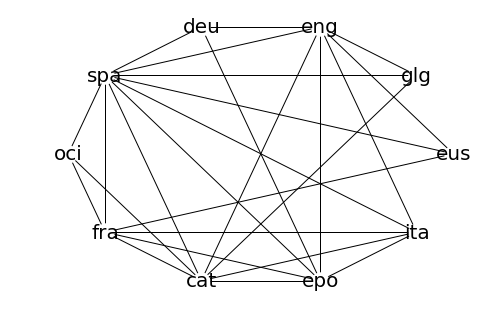

In [30]:
l1, l2 = 'fra','eng'
n = 10
%time get_relevant_languages(l1, l2)
%time load_file(l1, l2, n=n)
check_graph(l1, l2, n=n)

In [34]:
change_encoding('spa-eng')

# Evaluation

In [1]:
from tool.evaluation import *
from tool.functions import *

In [2]:
%time G = built_from_file('spa-eng')

%time l1, l2 = dictionaries('spa', 'eng')

Wall time: 55.9 s
Wall time: 3.83 s


In [3]:
import random
candidates = random.sample(l1, 10000)
pairs = []
for i in candidates:
    if i in G.nodes():
        s = FilteredList(list(G.neighbors(i))).lang('eng')
        if len(s) == 1:
            n = G.number_of_edges(s[0], i) + G.number_of_edges(i, s[0])
            pairs.append((i, s[0], n))
print (len(pairs))
pairs2 = pairs[:1000]

2124


In [4]:
result = evaluate(G, pairs2, 'spa', 'eng', 4)

In [5]:
sum(result)/10

44.182476556381374

In [7]:
import matplotlib.pyplot as plt

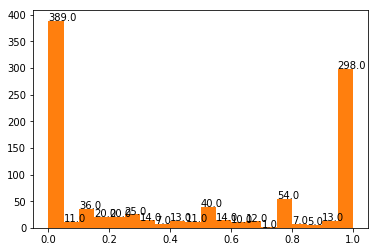

In [8]:
bins = 20
plt.hist(result, bins=bins)
arr=plt.hist(result,bins=bins)
for i in range(bins):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))
plt.show()

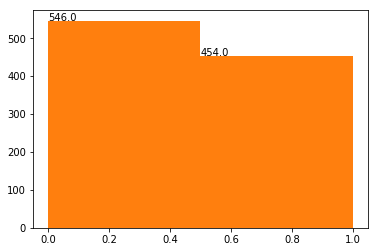

In [9]:
bins = 2
plt.hist(result, bins=bins)
arr=plt.hist(result,bins=bins)
for i in range(bins):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))
plt.show()